# Predicting Electricity Grid Imbalance Direction Using Time Series and Machine Learning

This notebook predicts the **direction** (positive or negative) of electricity grid imbalance at the next time step (15 minutes). The workflow combines **time series analysis** with **feature engineering** to transform the data for machine learning models, including **Random Forest** and **XGBoost**.

## Workflow Overview

### 1. Time Series Analysis
   - **Objective**: Understand the temporal structure of **target imbalance** as a time series which is the target variable.
   - **Method**: We check for stationarity and apply differencing if necessary to remove trends. This prepares the target variable for predictive modeling.
   - **Prediction** : Use an ARIMA + GARCH model to forecast the **value** of the grid imbalance at \( t+1 \). Then, check if the predicted and actual values have the **same sign** (positive or negative) to compute directional accuracy.


### 2. Feature Engineering for Machine Learning
   - **Lagged Features**: Generate **hourly** and **weekly lags** for imbalance and other key variables to capture both short- and long-term patterns.
   - **Rolling Statistics**: Calculate rolling means and standard deviations for short-term volatility insights.
   - **Price Interactions**: Create interactions between long and short prices to capture price-driven influences on imbalance.
   - **Time-Based Features**: Encode hour, day of the week, weekend/weekday, and business hours to account for periodic demand fluctuations.
   - **Extreme Value Indicators**: Flag extreme imbalances to highlight unusual conditions.

### 3. Model Training and Rolling Forecast
   - **Train-Test Split**: 80% of the data is used for training, and 20% is reserved for testing with a **rolling forecast** setup.
   - **Models**: 
     - **Logistic Regression** serves as a benchmark.
     - **Random Forest** and **XGBoost** are optimized through `GridSearchCV` with **TimeSeriesSplit** for hyperparameter tuning.
   - **Directional Accuracy**: The primary metric is directional accuracy, indicating how well the model predicts the next imbalance direction.

### 4. Feature Importance and Results
   - **Feature Importance**: We analyze feature importances to understand the influence of engineered features on model performance.
   - **Accuracy TS** := 0.850
   - **Accuracy Logistic regression** : Logistic regression := 0.798
   - **Accuracy Logistic regression** : Random Forest := 0.850
   - **Accuracy Logistic regression** : Xgboost = :0.873
   

### 5. Conclusion: The final results compare model performance and highlight key predictive features, providing a foundation for more complex forecasting models in electricity grid management. XGBoost winner model for classifying the directon of the imbalance of the grid


In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from tqdm import tqdm
import scipy.stats as stats
from arch import arch_model
#sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score



In [2]:
#File path for pandas df
file_path = "control-area-balance-2024.xlsx"
df = pd.read_excel(file_path)# sheet_name = "Zeitreihen0h15")
#Rename columns 
df.rename(columns= {"Total System Imbalance (Positiv = long / Negativ = short)" : "target_imbalance", "Date Time" : "date"}, inplace = True)
df.date = pd.to_datetime(df.date, dayfirst=True)
#Rename columns 
df.date = pd.to_datetime(df.date, dayfirst=True)
df.set_index("date", inplace=True)


<Axes: title={'center': 'Target imbalance'}, xlabel='date'>

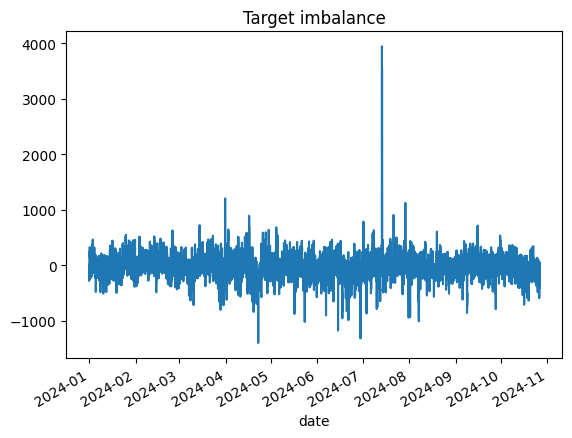

In [3]:
#Plottig
df["target_imbalance"].plot(title="Target imbalance")

Significant outlier around mid July 2024, should be accounted for :

In [4]:
print(df["target_imbalance"].describe())

count    28796.000000
mean       -28.019994
std        182.444970
min      -1400.014893
25%       -117.081508
50%        -24.133081
75%         67.668183
max       3944.447090
Name: target_imbalance, dtype: float64


In [5]:
# Setting a threshold based on the 99th percentile
threshold = df['target_imbalance'].quantile(0.99)

# Capping values above the threshold to the 99th percentile value
df['target_imbalance'] = np.where(df['target_imbalance'] > threshold, threshold, df['target_imbalance'])

print(f'The 99th quantile is = {threshold}')
print("----------------------------------------------------------")
print(df["target_imbalance"].describe())

The 99th quantile is = 409.7907998333335
----------------------------------------------------------
count    28796.000000
mean       -29.468506
std        175.555920
min      -1400.014893
25%       -117.081508
50%        -24.133081
75%         67.668183
max        409.790800
Name: target_imbalance, dtype: float64


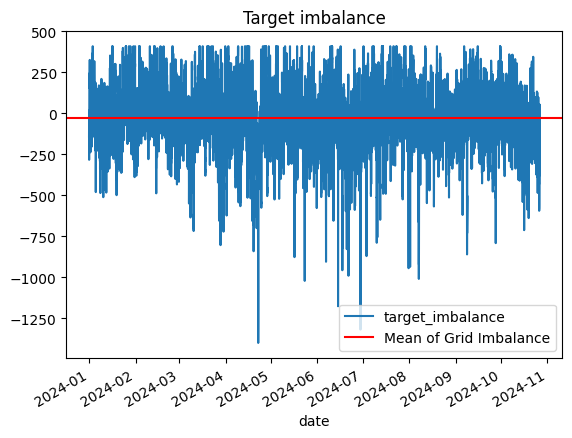

In [14]:
#re-plottig
df["target_imbalance"].plot(title="Target imbalance")
# only one line may be specified; full height
plt.axhline(y = df["target_imbalance"].mean(), color = 'r', label='Mean of Grid Imbalance')


plt.legend()
plt.show()

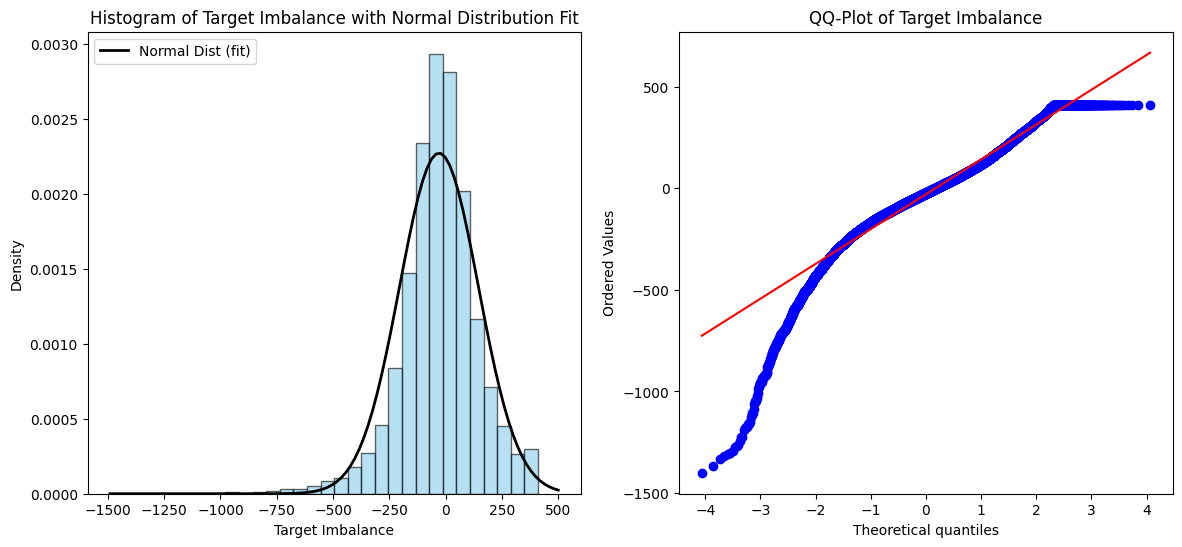

The target variable is not normally distributed (reject H0).


/home/atonra/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 28796.
  res = hypotest_fun_out(*samples, **kwds)


In [94]:
# Calculate the mean and standard deviation of target_imbalance
mean = df["target_imbalance"].mean()
std_dev = df["target_imbalance"].std()

# Plot histogram with a fitted normal distribution
plt.figure(figsize=(14, 6))

# Histogram with normal distribution overlay
plt.subplot(1, 2, 1)
plt.hist(df["target_imbalance"], bins=30, density=True, color="skyblue", edgecolor="black", alpha=0.6)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std_dev)
plt.plot(x, p, "k", linewidth=2, label="Normal Dist (fit)")
plt.title("Histogram of Target Imbalance with Normal Distribution Fit")
plt.xlabel("Target Imbalance")
plt.ylabel("Density")
plt.legend()

# QQ-Plot
plt.subplot(1, 2, 2)
stats.probplot(df["target_imbalance"], dist="norm", plot=plt)
plt.title("QQ-Plot of Target Imbalance")

plt.show()

# Conduct a normality test (Shapiro-Wilk test)
stat, p_value = stats.shapiro(df["target_imbalance"].dropna())

# Check the result
alpha = 0.05
if p_value > alpha:
    print("The target variable is normally distributed (fail to reject H0).")
else:
    print("The target variable is not normally distributed (reject H0).")



After removing outliers.
Let's inspect if our TS is stationary at 5% level.

In [95]:
#Function that computes adfuller test as well KPSS

def stationarity_tests(time_series) : 

        # Check Stationarity with ADF test on weekly differenced data

    adf_result = adfuller(time_series)

    print('ADF Statistic:', adf_result[0])

    print('p-value:', adf_result[1])



    

    kpss_stat, p_value, _, _ = kpss(time_series, regression='c')

    print("KPSS Statistic:", kpss_stat)

    print("p-value:", p_value)

    if p_value > 0.05:

        print("Series is likely stationary (fail to reject null hypothesis).")

    else:

        print("Series is likely non-stationary (reject null hypothesis).")
        

# Function to plot ACF and PACF for a single series
def plot_acf_pacf(series, title="Time Series"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # ACF
    plot_acf(series, ax=axes[0], lags=20)
    axes[0].set_title(f"ACF of {title}")
    
    # PACF
    plot_pacf(series, ax=axes[1], lags=20)
    axes[1].set_title(f"PACF of {title}")

    plt.tight_layout()
    plt.show()




In [96]:
ts = df["target_imbalance"]
stationarity_tests(ts)

print("------------------------------------")
ts_differenced = df["target_imbalance"].diff().dropna()
stationarity_tests(ts_differenced)






ADF Statistic: -16.152924588403994
p-value: 4.549485799945779e-29
KPSS Statistic: 0.8892199275256641
p-value: 0.01
Series is likely non-stationary (reject null hypothesis).
------------------------------------


/tmp/ipykernel_275886/1945356617.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_value, _, _ = kpss(time_series, regression='c')


ADF Statistic: -36.52041189089226
p-value: 0.0
KPSS Statistic: 0.0005063548029766714
p-value: 0.1
Series is likely stationary (fail to reject null hypothesis).


/tmp/ipykernel_275886/1945356617.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, _, _ = kpss(time_series, regression='c')


Conflict between Dfuller and KPSS for the ts as well as its first differencing. Logically, there is a seasonality, let's introduce seasonality each hour and each month and difference this and re-check if stationarity applies

In [97]:
# Apply daily seasonal differencing (96 intervals for 15-minute data)
ts_hourly = ts.diff(96).dropna()

# Optional: Apply weekly seasonal differencing (672 intervals)
ts_seasonal_adjust = ts_hourly.diff(672).dropna()

stationarity_tests(ts_seasonal_adjust)




ADF Statistic: -18.619371068014797
p-value: 2.0618997147187568e-30
KPSS Statistic: 0.00507777341914494
p-value: 0.1
Series is likely stationary (fail to reject null hypothesis).


/tmp/ipykernel_275886/1945356617.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, _, _ = kpss(time_series, regression='c')


The first differencing and the seasonal differencing showed both stationarity let's inspect their acf and pacf plots

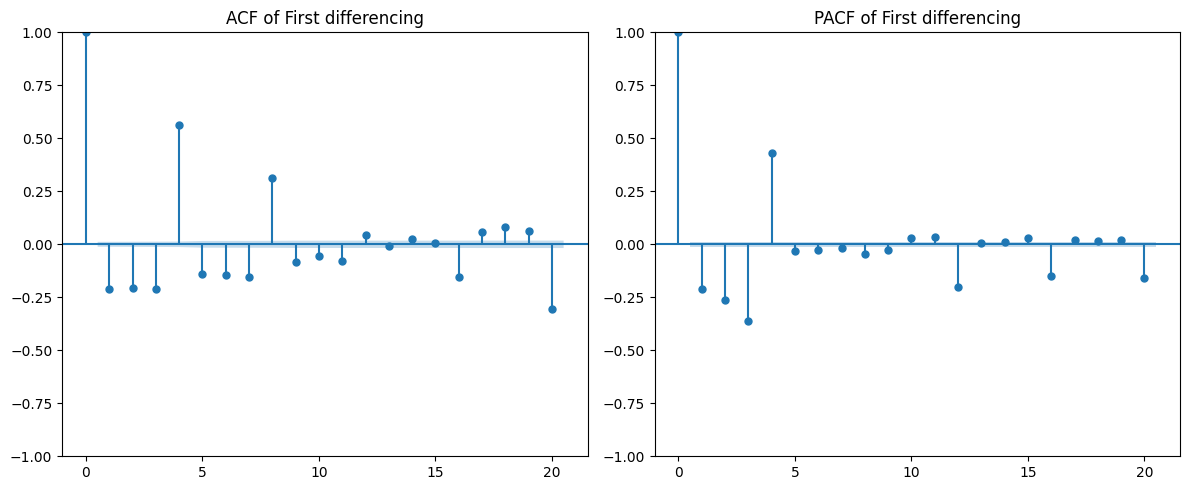

---------------------------------------------------------------------------------


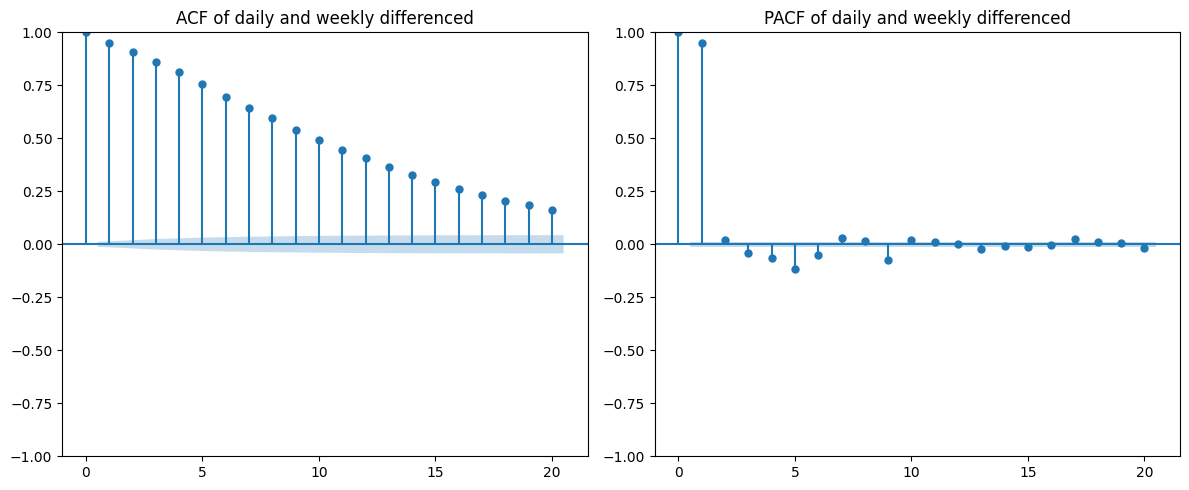

In [98]:
#plot using pre-defined function
plot_acf_pacf(ts_differenced, title="First differencing")
print("---------------------------------------------------------------------------------")
plot_acf_pacf(ts_seasonal_adjust, title="daily and weekly differenced")

The lower panel shows a signifcant cutoff at lag 2, suggesting AR(2). Let's try to fit the model.

* Ljung-Box Test (L1): The p-value of 0.00 suggests significant autocorrelation in the residuals at lag 1, indicating that the AR(1) model might not have fully captured all the dependencies in the data. -> autocorrelation
* Jarque-Bera Test: The p-value of 0.00 indicates that the residuals are not normally distributed, which is typical in time series with heavy tails or skewness. This may affect prediction accuracy in scenarios sensitive to normality. 
* Heteroskedasticity (H-statistic): The significant p-value suggests there’s instability in the residual variance (heteroskedasticity). This is often an indicator that a GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model could be beneficial to model the changing volatility over time. -> Heteroskedasticity
* USE GARCH

In [107]:
# Fit the ARIMA(2,0,0) model first to obtain residuals
arima_model = ARIMA(ts_seasonal_adjust, order=(1, 0, 0))
arima_fit = arima_model.fit()

# Extract residuals from the ARIMA model
arima_residuals = arima_fit.resid

# Fit a GARCH(1,1) model to the ARIMA residuals
garch_model = arch_model(arima_residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp="off")

# Display the summary of the ARIMA-GARCH model
print(garch_fit.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -164086.
Distribution:                  Normal   AIC:                           328180.
Method:            Maximum Likelihood   BIC:                           328213.
                                        No. Observations:                28028
Date:                Wed, Oct 30 2024   Df Residuals:                    28027
Time:                        16:55:40   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2398      0.450      0.533      0.594 [ -0.642,  1.12

* Omega (ω): 453.93, which represents the baseline level of volatility when there is no past shock or variance effect. The low p-value suggests this is highly significant.
* Alpha (α1): 0.1689, which measures the impact of recent shocks on volatility. This term is statistically significant, meaning recent events have an effect on current volatility.
* Beta (β1): 0.7861, indicating the persistence of volatility over time. The high value (close to 1) and strong significance suggest that volatility is highly persistent, meaning once volatility increases, it tends to stay elevated for some time.

* Comparison AR(1) And ARMA+ GARCH : Interpretation: The ARIMA-GARCH model has lower AIC and BIC values, suggesting a better fit to the data compared to the AR(1) model. This improvement comes from the GARCH component’s ability to model volatility clustering.
* The ARIMA-GARCH model is likely the better choice given the significant presence of heteroskedasticity in the time series, which it effectively captures.

##  ARIMA for forecast. - Walk Forward validation 


/tmp/ipykernel_275886/2299390546.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ts_seasonal_adjust.index = pd.date_range(start=ts_seasonal_adjust.index[0], periods=len(ts_seasonal_adjust), freq="15T")


In-Sample MAE: 66.77610785047416
In-Sample RMSE: 93.49577087309349
Out-of-Sample MAE: 53.799303758158636
Out-of-Sample RMSE: 80.13952936668792
In-Sample R-squared: 0.9055124010784851
Out-of-Sample R-squared: 0.682584331626523


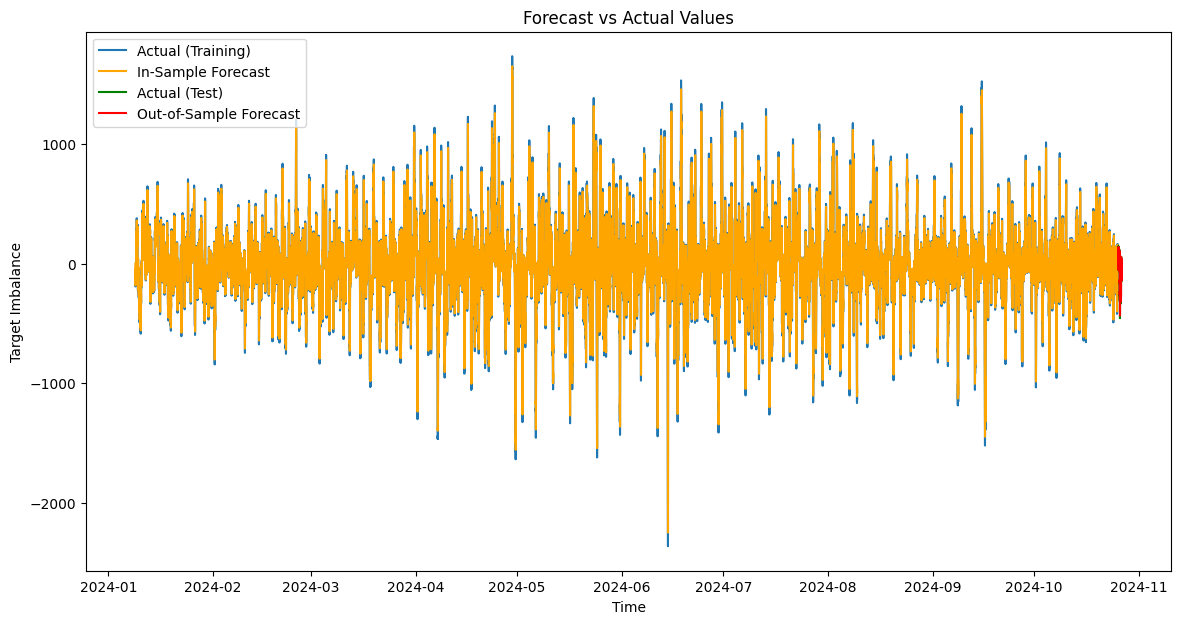

In [101]:
# Ensure the original time series has a fixed frequency
ts_seasonal_adjust.index = pd.date_range(start=ts_seasonal_adjust.index[0], periods=len(ts_seasonal_adjust), freq="15T")

# Define the forecast horizon for out-of-sample forecasting
forecast_horizon = 100

# Split the data into training and test sets
train_size = len(ts_seasonal_adjust) - forecast_horizon
train, test = ts_seasonal_adjust.dropna()[:train_size], ts_seasonal_adjust.dropna()[train_size:]

# Fit ARIMA(2,0,0) + GARCH(1,1) model on the training data
arima_model_train = ARIMA(train, order=(1, 0, 0))
arima_fit_train = arima_model_train.fit()
arima_residuals_train = arima_fit_train.resid

# GARCH on ARIMA residuals
garch_model_train = arch_model(arima_residuals_train, vol='Garch', p=1, q=1)
garch_fit_train = garch_model_train.fit(disp="off")

# In-sample forecast on the training set
in_sample_forecast = arima_fit_train.fittedvalues

# Out-of-sample forecast (one-step-ahead forecast for the test set)
out_of_sample_forecast = []
history = list(train)  # Start with the training data
for t in range(len(test)):
    model = ARIMA(history, order=(1, 0, 0)).fit()
    next_prediction = model.forecast()[0]
    out_of_sample_forecast.append(next_prediction)
    history.append(test.iloc[t])  # Update history with the actual test value

# Calculate performance metrics for in-sample and out-of-sample forecasts
in_sample_mae = mean_absolute_error(train, in_sample_forecast)
in_sample_rmse = np.sqrt(mean_squared_error(train, in_sample_forecast))
in_sample_rsquared = r2_score(train, in_sample_forecast)
out_of_sample_mae = mean_absolute_error(test, out_of_sample_forecast)
out_of_sample_rmse = np.sqrt(mean_squared_error(test, out_of_sample_forecast))
out_sample_rsquared = r2_score(test, out_of_sample_forecast)

# Print performance metrics
print("In-Sample MAE:", in_sample_mae)
print("In-Sample RMSE:", in_sample_rmse)
print("Out-of-Sample MAE:", out_of_sample_mae)
print("Out-of-Sample RMSE:", out_of_sample_rmse)
print("In-Sample R-squared:", in_sample_rsquared)
print("Out-of-Sample R-squared:", out_sample_rsquared)


# Plot the forecasts vs actual values
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Actual (Training)')
plt.plot(train.index, in_sample_forecast, label='In-Sample Forecast', color='orange')
plt.plot(test.index, test, label='Actual (Test)', color='green')
plt.plot(test.index, out_of_sample_forecast, label='Out-of-Sample Forecast', color='red')
plt.legend(loc='upper left')
plt.title("Forecast vs Actual Values")
plt.xlabel("Time")
plt.ylabel("Target Imbalance")
plt.show()


Use ARIMA + GARCH -> GARCH HERE WILL GIVE A CONFIDENCE INTERVAL OF THE PREDICTION BY USING THE PREDICTED VOLATILITY

In [102]:
out_of_sample_forecast = []
lower_forecast_bound = []
upper_forecast_bound = []
history = list(train)

for t in range(len(test)):
    # Step 1: Fit ARIMA model on current history
    arima_model = ARIMA(history, order=(1, 0, 0)).fit()
    arima_forecast = arima_model.forecast()[0]
    
    # Step 2: Fit GARCH model on ARIMA residuals to capture volatility
    arima_residuals = arima_model.resid
    garch_model = arch_model(arima_residuals, vol='Garch', p=1, q=1)
    garch_fit = garch_model.fit(disp="off")
    garch_forecast = garch_fit.forecast(horizon=1).variance.values[-1][0]  # One-step-ahead variance

    # Mean forecast from ARIMA
    combined_forecast = arima_forecast

    # Volatility forecast from GARCH (standard deviation is square root of variance)
    forecast_volatility = np.sqrt(garch_forecast)

    # Prediction intervals
    lower_bound = combined_forecast - 1.96 * forecast_volatility
    upper_bound = combined_forecast + 1.96 * forecast_volatility

    # Append the point forecast and intervals
    out_of_sample_forecast.append(combined_forecast)
    lower_forecast_bound.append(lower_bound)
    upper_forecast_bound.append(upper_bound)

    # Step 3: Update history with the actual observed value from the test set
    history.append(test.iloc[t])  # Ensures no forward-looking bias


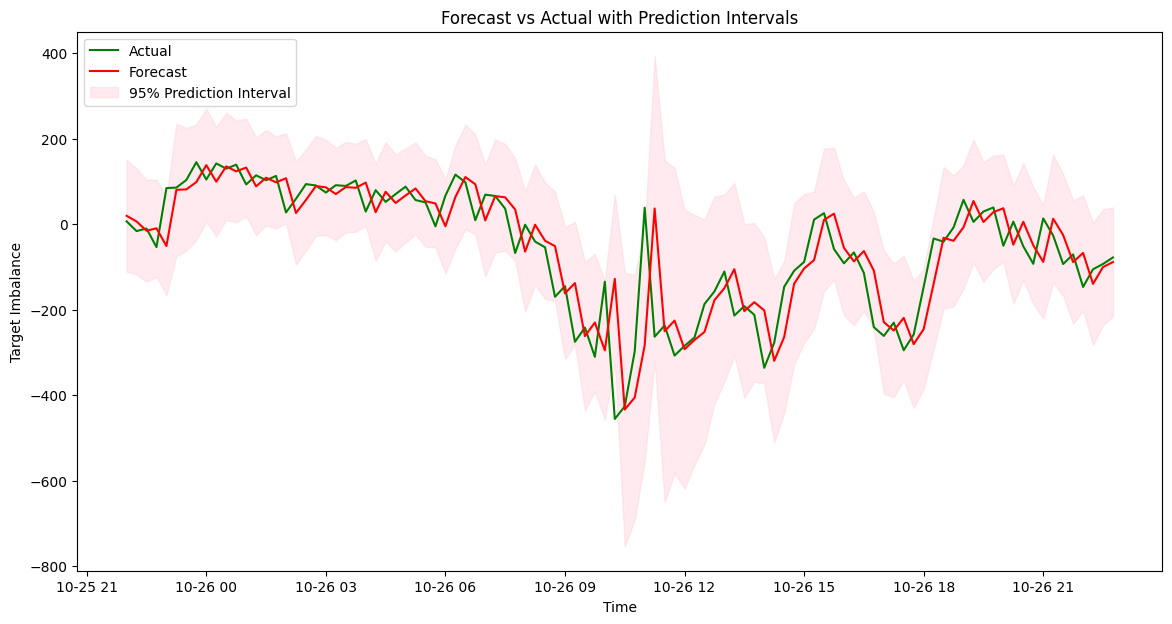

In [103]:
# Forecast vs. Actual with Prediction Intervals
plt.figure(figsize=(14, 7))
plt.plot(test.index, test, label='Actual', color='green')
plt.plot(test.index, out_of_sample_forecast, label='Forecast', color='red')
plt.fill_between(
    test.index,
    lower_forecast_bound,
    upper_forecast_bound,
    color='pink',
    alpha=0.3,
    label='95% Prediction Interval'
)
plt.legend(loc='upper left')
plt.title("Forecast vs Actual with Prediction Intervals")
plt.xlabel("Time")
plt.ylabel("Target Imbalance")
plt.show()




The goal of this analysis is to predict the directionality (sign) of the electricity grid imbalance, rather than its exact value. We aim to forecast whether there will be a surplus (positive imbalance) or deficit (negative imbalance) in the grid. This initial model will serve as a benchmark for comparison against machine learning models such as Random Forest and XGBoost using additional features.

In [104]:

# Convert the forecasted and actual values to binary signs: 1 for positive, -1 for negative
forecasted_signs = np.sign(out_of_sample_forecast)  # Sign of forecasted values
actual_signs = np.sign(test)  # Sign of actual values

# Calculate directional accuracy: the percentage of matching signs
directional_matches = forecasted_signs == actual_signs  # Boolean array where True indicates correct direction
directional_accuracy = np.mean(directional_matches)  # Calculate the accuracy as the mean of matches

print(f'TS model: directional accuracy = {directional_accuracy:.4f}')


TS model: directional accuracy = 0.8500


### ML models

Feature Engineering -> Use lagged values hourly and weekly to capture dependencies

# Feature Engineering for Electricity Grid Data

In this dataset, we apply various feature engineering techniques to enhance the predictive power of our model. Each engineered feature is designed to capture temporal patterns, volatility, and price-driven relationships within the electricity grid data, allowing the model to make more informed predictions about grid imbalances. Below is an explanation of each feature and its logical significance.

### 1. Hourly and Weekly Lags for Each Feature
   - **Definition**: We generate hourly and weekly lags (4 and 672 intervals respectively, given 15-minute intervals) for each feature, including `target_imbalance`.
   - **Purpose**: 
      - **Hourly lags** capture short-term fluctuations, which are important in high-frequency data like electricity grid metrics.
      - **Weekly lags** capture longer-term, cyclic behaviors that may repeat weekly, helping the model recognize patterns associated with similar conditions in the past.
   - **Significance**: These lags help the model learn from similar past conditions at different timescales, which can be especially useful in identifying trends and seasonality.

### 2. Shifted Target Variable (Direction at \( t+1 \))
   - **Definition**: The `direction` variable is created by shifting `target_imbalance` by -1, indicating whether the next time step will be positive or negative.
   - **Purpose**: This setup enables the model to learn the direction of imbalance (positive or negative) at \( t+1 \) based on information available up to \( t \).
   - **Significance**: This binary target (1 if positive, 0 if negative) provides a clear signal for classification models to predict future trends.

### 3. Rolling Statistics
   - **Definitions**:
     - `imbalance_rolling_mean_hour`: 1-hour rolling mean for `target_imbalance` (4 intervals).
     - `imbalance_rolling_std_day`: Daily rolling standard deviation (96 intervals).
     - `imbalance_deviation_hour`: Difference between current imbalance and its 1-hour rolling mean.
   - **Purpose**: Rolling statistics capture recent trends and volatility, allowing the model to understand the variability of imbalance over short and long timeframes.
   - **Significance**: This helps the model assess whether a recent imbalance is part of a stable trend or an unusual deviation, which can signal potential future reversals.

### 4. Price-Driven Features
   - **Definitions**:
     - `price_diff`: Difference between `AE-Preis short` and `AE-Preis long`.
     - `price_imbalance_interaction`: Interaction between `AE-Preis short` and `target_imbalance`.
   - **Purpose**: These features capture the relationship between price metrics and imbalances, as prices often reflect underlying supply and demand pressures.
   - **Significance**: Price differences and interactions can indicate market pressures, helping the model associate price behaviors with surplus or deficit conditions.

### 5. Time-Based Features
   - **Definitions**:
     - `hour`: Hour of the day.
     - `day_of_week`: Day of the week.
     - `is_weekend`: Binary indicator for weekends.
     - `is_business_hour`: Binary indicator for business hours (9 AM to 6 PM).
   - **Purpose**: These temporal features help the model differentiate between peak and off-peak hours, weekdays and weekends, and typical business hours.
   - **Significance**: Imbalance patterns often vary by time of day and week. For example, demand may increase during business hours or decrease on weekends, so these indicators allow the model to adjust predictions based on known patterns.

### 6. Lagged Volatility and Extreme Value Indicators
   - **Definitions**:
     - `imbalance_volatility_lag1`: 1-step lagged volatility (daily standard deviation).
     - `extreme_imbalance`: Indicator of whether `target_imbalance` is in the top 5% of values.
   - **Purpose**: High volatility and extreme imbalance values often predict corrections or reversals, as the system may attempt to return to stability.
   - **Significance**: By flagging these conditions, the model can recognize high-volatility or extreme situations, which may signal directional changes in the imbalance.

### 7. Cumulative Sum of Imbalances
   - **Definition**: `cumulative_imbalance` is the cumulative sum of `target_imbalance`.
   - **Purpose**: This feature indicates the ongoing buildup of surplus or deficit over time.
   - **Significance**: Accumulated imbalances can indicate long-term trends and potential thresholds where corrective actions are likely, helping the model understand the sustained direction of imbalances.

### 8. Ratios Between Key Features
   - **Definition**: `FRCE_ratio` is the ratio of `FRCE+ (Import)` to `FRCE- (Export)`.
   - **Purpose**: Ratios between import and export metrics can indicate grid balancing behaviors and demand-supply shifts.
   - **Significance**: Ratios provide context on the relative magnitude of grid inputs and outputs, which can reveal stress points or imbalances within the grid.

### 9. Custom Aggregates Over Specified Periods
   - **Definition**: `weekly_sum_imbalance` is the sum of `target_imbalance` over a week (672 intervals).
   - **Purpose**: Summing over a week captures cumulative behaviors, providing a long-term context for imbalances.
   - **Significance**: This feature enables the model to incorporate sustained patterns and trends, improving predictions for imbalances that follow weekly cycles.

### Final Processing
- **Dropping NaNs**: After generating these features, rows with NaNs (resulting from shifts, rolling calculations, and cumulative sums) are dropped, ensuring that each observation has complete data.

These features are engineered to capture both short-term fluctuations and long-term trends, allowing the model to make predictions that are responsive to both immediate patterns and broader cyclical behaviors.


In [42]:
# Assuming `df` is your DataFrame with all the original features and 'target_imbalance'
# Define lags for hourly and weekly intervals
hourly_lag = 4  # 1 hour (4 * 15-minute intervals)
weekly_lag = 672  # 1 week (4 * 24 * 7 intervals)

# Apply hourly and weekly lags to each feature, including target_imbalance
for column in df.columns:
    df[f'{column}_lag_hourly'] = df[column].shift(hourly_lag)
    df[f'{column}_lag_weekly'] = df[column].shift(weekly_lag)

# Shift target variable by -1 to predict the direction at t+1
df['direction'] = (df['target_imbalance'].shift(-1) > 0).astype(int)  # 1 if positive, 0 if negative at t+1

# Additional Feature Engineering

# 1. Rolling statistics
df['imbalance_rolling_mean_hour'] = df['target_imbalance'].rolling(window=4).mean()
df['imbalance_rolling_std_day'] = df['target_imbalance'].rolling(window=96).std()
df['imbalance_deviation_hour'] = df['target_imbalance'] - df['imbalance_rolling_mean_hour']

# 2. Price-driven features
df['price_diff'] = df['AE-Preis short'] - df['AE-Preis long']
df['price_imbalance_interaction'] = df['AE-Preis short'] * df['target_imbalance']

# 3. Time-based features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_business_hour'] = df['hour'].between(9, 18).astype(int)

# 4. Lagged volatility and extreme value indicators
df['imbalance_volatility_lag1'] = df['imbalance_rolling_std_day'].shift(1)
df['extreme_imbalance'] = (df['target_imbalance'] > df['target_imbalance'].quantile(0.95)).astype(int)

# 5. Cumulative sum of imbalances
df['cumulative_imbalance'] = df['target_imbalance'].cumsum()

# 6. Ratios between key features over time
df['FRCE_ratio'] = df['FRCE+ (Import)'] / (df['FRCE- (Export)'] + 1e-5)  # Avoid division by zero

# 7. Custom aggregates over specified periods
df['weekly_sum_imbalance'] = df['target_imbalance'].rolling(window=672).sum()  # Sum over one week

# Drop rows with NaNs created by shifting, rolling, and other operations
df_features_engineering = df.dropna()




Logistic Regression

In [43]:
# Define features (X) and target (y)
X = df_features_engineering.drop(columns=['target_imbalance', 'direction'])
y = df_features_engineering['direction']

# Set initial training and test indices, avoiding overlap
train_size = int(0.8 * len(X))  # 80% for initial training
X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
X_test, y_test = X.iloc[train_size:], y.iloc[train_size :] 

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize logistic regression model without cross-validation for faster training
log_reg = LogisticRegression(max_iter=500, C=1.0, random_state=42, solver="lbfgs")

# Step 1: Rolling Forecast with Simplified Logistic Regression
rolling_predictions = []

# Rolling forecast loop with tqdm for progress display
for i in tqdm(range(len(X_test)), desc="Rolling Forecast Progress (Simplified Logistic Regression)"):
    # Fit logistic regression on the current training set
    log_reg.fit(X_train, y_train)
    
    # Predict the next point (t+1) in the test set
    y_pred = log_reg.predict(X_test[[i]])  # Predict for the current test point
    rolling_predictions.append(y_pred[0])  # Store the prediction
    
    # Update the training set with the current test observation
    X_train = np.vstack([X_train, X_test[[i]]])
    y_train = np.append(y_train, y_test.iloc[i])

# Calculate directional accuracy for logistic regression
accuracy = accuracy_score(y_test[:len(rolling_predictions)], rolling_predictions)
print("Rolling Directional Accuracy with Simplified Logistic Regression:", accuracy)



Rolling Forecast Progress (Simplified Logistic Regression): 100%|██████████| 5624/5624 [55:51<00:00,  1.68it/s] 

Rolling Directional Accuracy with Simplified Logistic Regression: 0.798719772403983


### Random Forest 

- We will decrease the dataset here to be able to train the models, taking the 1st 5000 points

In [44]:
# Take only the first 5000 samples for both features and target
X = df_features_engineering.drop(columns=['target_imbalance', 'direction']).iloc[:5000]
y = df_features_engineering['direction'].iloc[:5000]

# Set initial training and test indices, avoiding overlap
train_size = int(0.8 * len(X))  # 80% for initial training
X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
X_test, y_test = X.iloc[train_size :], y.iloc[train_size :]  # Start test set one index after the training set

# Step 1: Hyperparameter Tuning on Initial Training Set Using TimeSeriesSplit and GridSearchCV
# Parameter grid (48 combinations)
param_grid = {
    'n_estimators': [100, 200],          # Number of trees
    'max_depth': [10, 20, None],         # Limit depth options
    'min_samples_split': [5, 10],        # Minimum samples per split
    'min_samples_leaf': [1, 2],          # Minimum samples per leaf
    'max_features': ['sqrt', 'log2', None]  # Only valid options
}


# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Use TimeSeriesSplit with fewer splits (e.g., 3-fold)
tscv = TimeSeriesSplit(n_splits=3)

# Set up GridSearchCV with TimeSeriesSplit for time series cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,    # TimeSeriesSplit CV
    scoring='accuracy',
    n_jobs=-1,  # Use all cores
    verbose=1
)

# Fit grid search on the initial training set
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters from Grid Search:", best_params)

# Initialize Random Forest with best parameters from grid search
best_rf = RandomForestClassifier(**best_params, random_state=42)

# Step 2: Rolling Forecast with Tuned Model and Progress Bar
rolling_predictions = []

# Rolling forecast loop with tqdm for progress display
for i in tqdm(range(len(X_test)), desc="Rolling Forecast Progress"):
    # Fit the tuned model on the current training set
    best_rf.fit(X_train, y_train)
    
    # Predict the next point (t+1) in the test set
    y_pred = best_rf.predict(X_test.iloc[[i]])  # Predict for the current test point
    rolling_predictions.append(y_pred[0])  # Store the prediction
    
    # Update the training set with the current test observation
    X_train = pd.concat([X_train, X_test.iloc[[i]]])
    y_train = pd.concat([y_train, y_test.iloc[[i]]])

# Calculate directional accuracy
accuracy = accuracy_score(y_test[:len(rolling_predictions)], rolling_predictions)
print("Rolling Directional Accuracy with Tuned Random Forest:", accuracy)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters from Grid Search: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


Rolling Forecast Progress: 100%|██████████| 1000/1000 [16:49<00:00,  1.01s/it]

Rolling Directional Accuracy with Tuned Random Forest: 0.85


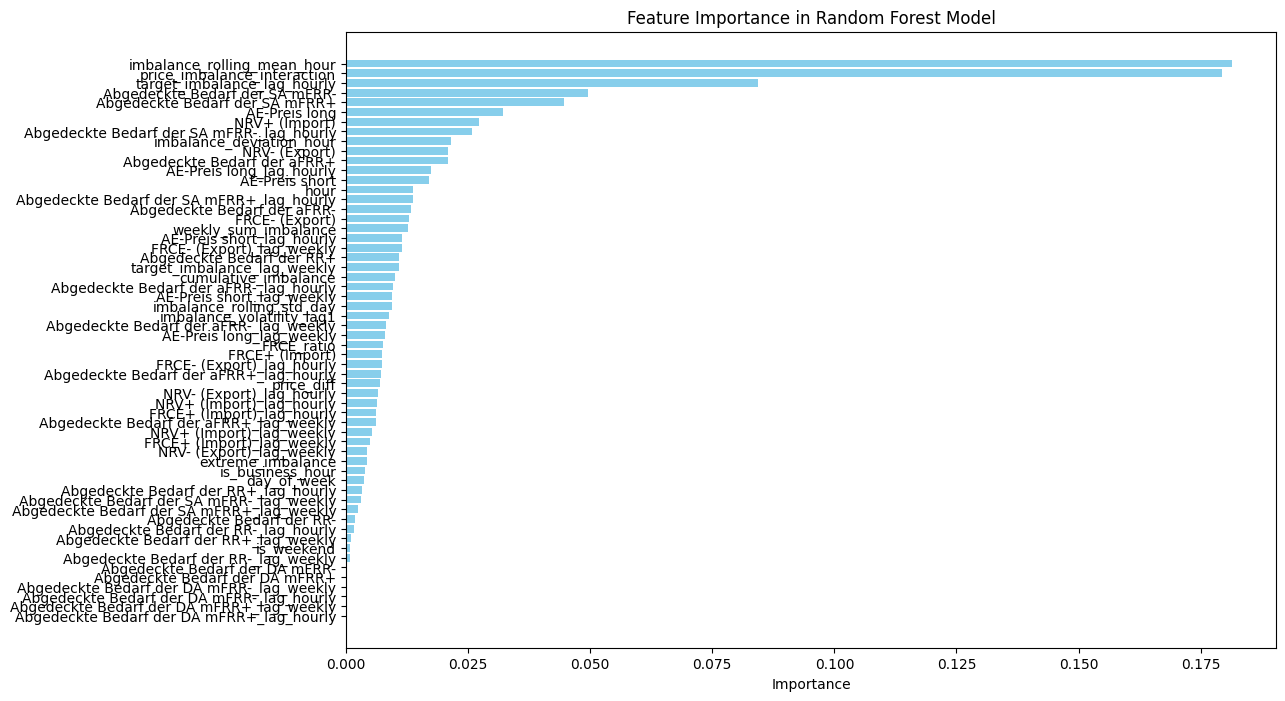

In [45]:

# Final fit on the entire X_train after rolling forecast
best_rf.fit(X_train, y_train)

# Retrieve feature importances
importances = best_rf.feature_importances_
feature_names = X.columns  # Use original feature names

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()  # To have the most important features at the top
plt.show()


### XGboost

In [46]:
# Take only the first 1000 samples for both features and target
X = df_features_engineering.drop(columns=['target_imbalance', 'direction']).iloc[:5000]
y = df_features_engineering['direction'].iloc[:5000]

# Set initial training and test indices, avoiding overlap
train_size = int(0.8 * len(X))  # 80% for initial training
X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
X_test, y_test = X.iloc[train_size:], y.iloc[train_size :]  # Start test set one index after the training set

# Step 1: Hyperparameter Tuning on Initial Training Set Using TimeSeriesSplit and GridSearchCV
param_grid = {
    'n_estimators': [50, 100],            # Number of trees
    'max_depth': [3, 6, 10],              # Depth of trees
    'learning_rate': [0.01, 0.1, 0.2],    # Learning rate (shrinkage)
    'subsample': [0.8, 1.0],              # Subsampling ratio for each tree
    'colsample_bytree': [0.8, 1.0]        # Subsample ratio of columns for each tree
}

# Initialize the model
xgb = XGBClassifier(random_state=42, eval_metric='logloss')

# Use TimeSeriesSplit with fewer splits (e.g., 3-fold)
tscv = TimeSeriesSplit(n_splits=3)

# Set up GridSearchCV with TimeSeriesSplit for time series cross-validation
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,    # TimeSeriesSplit CV
    scoring='accuracy',
    n_jobs=-1,  # Use all cores
    verbose=1
)

# Fit grid search on the initial training set
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters from Grid Search:", best_params)

# Initialize XGBoost with best parameters from grid search
best_xgb = XGBClassifier(**best_params, random_state=42, eval_metric='logloss')

# Step 2: Rolling Forecast with Tuned Model and Progress Bar
rolling_predictions = []

# Rolling forecast loop with tqdm for progress display
for i in tqdm(range(len(X_test)), desc="Rolling Forecast Progress"):
    # Fit the tuned model on the current training set
    best_xgb.fit(X_train, y_train)
    
    # Predict the next point (t+1) in the test set
    y_pred = best_xgb.predict(X_test.iloc[[i]])  # Predict for the current test point
    rolling_predictions.append(y_pred[0])  # Store the prediction
    
    # Update the training set with the current test observation
    X_train = pd.concat([X_train, X_test.iloc[[i]]])
    y_train = pd.concat([y_train, y_test.iloc[[i]]])

# Calculate directional accuracy
accuracy = accuracy_score(y_test[:len(rolling_predictions)], rolling_predictions)
print("Rolling Directional Accuracy with Tuned XGBoost:", accuracy)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters from Grid Search: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}


Rolling Forecast Progress: 100%|██████████| 1000/1000 [11:07<00:00,  1.50it/s]

Rolling Directional Accuracy with Tuned XGBoost: 0.873


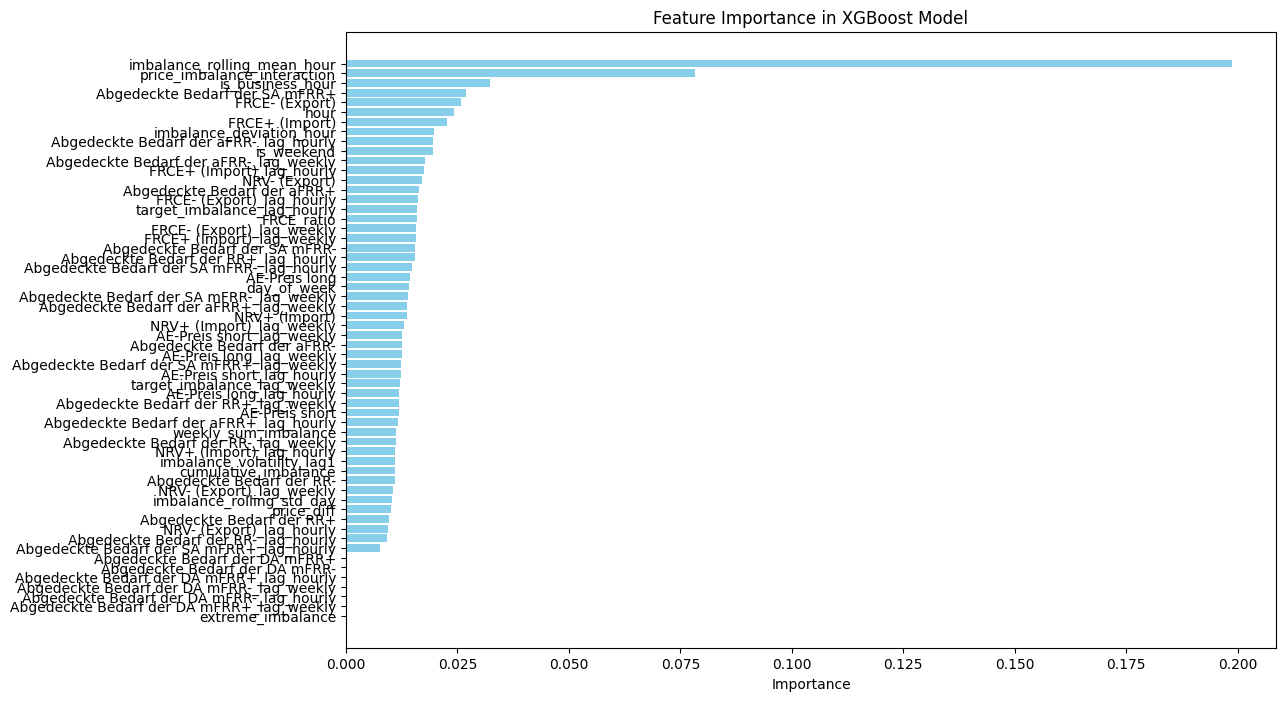

In [47]:
# Final fit on the entire X_train after rolling forecast
best_xgb.fit(X_train, y_train)

# Retrieve feature importances
importances = best_xgb.feature_importances_
feature_names = X.columns  # Use original feature names

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in XGBoost Model')
plt.gca().invert_yaxis()  # To have the most important features at the top
plt.show()
